In [ ]:
# BELOW IS A "SMART CONTRACT ANALYZER", THAT TAKES IN A PDF (A CONTRACT) AND IT AUTOMATES THE CONTRACT ANALYSIS PIPELINE USING PYTHON, NLP AND MACHINE LEARNING
# TO EXTRACT KEY CLAUSES, CLASSIFY RISKS AND MATCH IT TO SUPPLIER TO ENHANCE DECISION MAKING AND REDUCE THE MANUAL TIME TAKEN TO GO THROUGH EACH PDF AND ACCOMPLISH THIS TASK.
# THIS IS A PROTOTYPE AND A BIGGER, BETTER VERSION OF THIS SOLUTION WOULD USE BETTER ML ALGORITHMS AND LIBRARIES.
# I RAN THE CODEBLOCKS AND THE OUTPUT CAN BE SEEN BELOW.
# THIS IS DONE BASED ON THE "Sample Procurement Contract.pdf" and "historical_contracts", AS IT CAN BE SEEN IN THE FILES.

# run this code block first if you want to see the code in action :)

pip install pypdf spacy

In [ ]:
# import statements
import json, spacy, re, os
from pypdf import PdfReader
from sentence_transformers import SentenceTransformer, util

# constants
CLAUSE_KEYWORDS = {
    "termination": ["terminate", "termination", "end of agreement"],
    "payment": ["payment", "invoice", "payable"],
    "jurisdiction": ["jurisdiction", "governing law", "court"],
    "penalty": ["penalty", "breach", "damages", "fine"],
    "renewal": ["renewal", "extend", "auto-renew", "renew"]
}
PATH_TO_PDF = "Sample_Contract.pdf"
HISTORICAL_DIRECTORY = "./historical_contracts"

# extract text from the sample contract pdf from each page
reader = PdfReader(PATH_TO_PDF)
text = ""
for i in range(len(reader.pages)):
    page = reader.pages[i]
    page_text = page.extract_text(extraction_mode="layout")
    if page_text:
        text += page_text.replace("\n", " ")

# splitting document into blocks based on contract sections
contract_blocks = re.split(r"(?i)(?:Signed,|Signatures:)", text)

# tokenizing each block separately
nlp = spacy.load("en_core_web_sm")

# processing each block independently
for block_num, block_text in enumerate(contract_blocks):
    block_text = block_text.strip()
    if not block_text:
        continue

    print(f"\n--- Contract Block {block_num + 1} ---")
    document = nlp(block_text)
    sentences = [re.sub(r"\s{2,}", " ", sent.text.strip()) for sent in document.sents if len(sent.text.strip().split()) > 3]

    # defining an empty dictionary to get all the clauses containing keywords from the contract
    extracted_clauses = {}

    # checking the presence of keywords for each sentence
    for sentence in sentences:
        for clause_type, keywords in CLAUSE_KEYWORDS.items():
            if clause_type not in extracted_clauses:
                if any(keyword.lower() in sentence.lower() for keyword in keywords):
                    extracted_clauses[clause_type] = re.sub(r"\d+\.\s*", "", sentence)

    print("\nExtracted Clauses:")
    for k, v in extracted_clauses.items():
        print(f"{k.title()}: {v}")

    # function to assess risk based on the contract clause
    def assess_risk(clauses):
        risk_reasons = []

        payment = clauses.get("payment", "").lower()

        # checking for payment terms
        payment_match = re.search(r"(\d{2,3})\s*days", payment)
        if payment_match:
            days = int(payment_match.group(1))
            if days > 60:
                risk_reasons.append(f"Payment term exceeds 60 days ({days} days)")

        # checking for termination
        termination = clauses.get("termination", "").lower()
        term_match = re.search(r"(\d{2,3})\s*days", termination)
        if term_match:
            days = int(term_match.group(1))
            if days > 60:
                risk_reasons.append(f"Termination period is too long ({days} days)")

        # checking for jurisdiction
        jurisdiction = clauses.get("jurisdiction", "").lower()
        if jurisdiction and not any(loc in jurisdiction for loc in ["canada", "ontario", "quebec", "british columbia"]):
            risk_reasons.append("Jurisdiction is foreign or unspecified")

        # improving penalty detection
        penalty = clauses.get("penalty", "").lower()
        if (not penalty or
            not any(p in penalty for p in ["charged", "incur", "%", "applies"]) or
            any(neg in penalty for neg in ["without penalty", "no penalty"])):
            risk_reasons.append("No penalty clause found")

        # checking for renewal
        renewal = clauses.get("renewal", "").lower()
        if "auto-renew" in renewal or "automatically renew" in renewal:
            risk_reasons.append("Auto-renewal clause present")

        # assigning risk based on the length of risk_reasons list
        if len(risk_reasons) >= 3:
            risk_level = "High"
        elif len(risk_reasons) == 2:
            risk_level = "Medium"
        else:
            risk_level = "Low"

        return {
            "overall_risk": risk_level,
            "reasons": risk_reasons
        }

    print("\nRisk Assessment:")
    print(json.dumps(assess_risk(extracted_clauses), indent=2))


## NOW SUPPLIER SIMILARITY MATCHING ##

# loading the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# example input
current_clauses = {
    "payment": "Payment shall be made within 60 days of receiving an invoice.",
    "termination": "Either party may terminate the agreement with 30 days' written notice.",
    "jurisdiction": "This Agreement shall be governed by the laws of Ontario, Canada.",
    "penalty": "",
    "renewal": "Agreement automatically renews annually unless terminated."
}

# computing clause embeddings for current contract
current_embeddings = {}
for clause, text in current_clauses.items():
    if text.strip():
        current_embeddings[clause] = model.encode(text, convert_to_tensor=True)

# loading and comparing to historical contracts
similarities = []
for file in os.listdir(HISTORICAL_DIRECTORY):
    if not file.endswith(".json"):
        continue

    with open(os.path.join(HISTORICAL_DIRECTORY, file)) as data_file:
        data = json.load(data_file)
        historical_clauses = data.get("clauses", {})
        vendor_name = data.get("vendor", file.replace(".json", ""))

        total_sim = 0
        matched_clauses = 0

        for clause_type, current_emb in current_embeddings.items():
            hist_text = historical_clauses.get(clause_type, "")
            if hist_text.strip():
                hist_emb = model.encode(hist_text, convert_to_tensor=True)
                sim_score = float(util.pytorch_cos_sim(current_emb, hist_emb))
                total_sim += sim_score
                matched_clauses += 1

        if matched_clauses:
            avg_sim = total_sim / matched_clauses
            similarities.append((vendor_name, round(avg_sim, 3)))

# sorting by similarity
similarities.sort(key=lambda x: x[1], reverse=True)

# finally, priniting the result
print("\nMost similar suppliers:")
for vendor, score in similarities[:5]:
    print(f"{vendor}: similarity {score}")


--- Contract Block 1 ---

Extracted Clauses:
Payment: Payment Terms: Payment shall be made within **60 days** of receiving an invoice.
Termination: Termination Clause: Either party may terminate the agreement with **30 days' written notice**. 
Jurisdiction: Jurisdiction: This Agreement shall be governed by the laws of **Ontario, Canada**. 
Renewal: Agreement automatically renews annually unless terminated.

Risk Assessment:
{
  "overall_risk": "Medium",
  "reasons": [
    "No penalty clause found",
    "Auto-renewal clause present"
  ]
}

--- Contract Block 2 ---

Extracted Clauses:
Termination: Termination: Buyer may terminate without penalty at any time with **7 days’ notice**.
Penalty: Termination: Buyer may terminate without penalty at any time with **7 days’ notice**.
Jurisdiction: Jurisdiction: This agreement is subject to the laws of **British Columbia**.

Risk Assessment:
{
  "overall_risk": "Low",
  "reasons": [
    "No penalty clause found"
  ]
}

--- Contract Block 3 ---

E

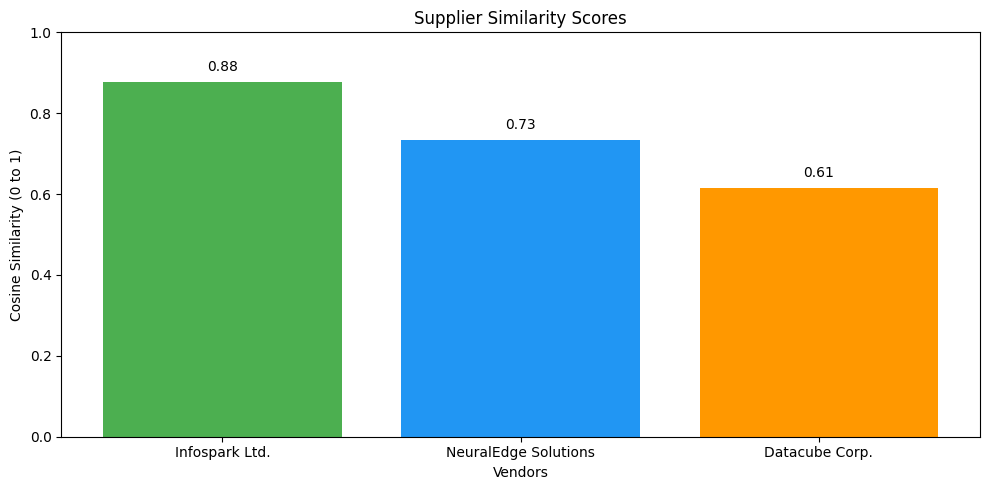

In [ ]:
# visualizing the output in a barchart

import matplotlib.pyplot as plt

# collecting the output of previous code block here
similarities = [
    ("Infospark Ltd.", 0.876),
    ("NeuralEdge Solutions", 0.733),
    ("Datacube Corp.", 0.614)
]

# separating names and scores
vendors, scores = zip(*similarities)

# creating the bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(vendors, scores, color=['#4CAF50', '#2196F3', '#FF9800'])
plt.ylim(0, 1)
plt.title("Supplier Similarity Scores")
plt.ylabel("Cosine Similarity (0 to 1)")
plt.xlabel("Vendors")

# annotating scores on bars
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{score:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
